In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import logging
import random
import time
import datetime

# Constants and Configurations
SCRAPERAPI_KEY = '135e1b572cf929a59af8cb3da6eb330a'
MAX_RETRIES = 3
DELAY_MIN = 3
DELAY_MAX = 6
CSV_FILE_PATH = 'Data/Export-NH-counties (Cleaned).xlsx - Sheet1.csv'
EXCEL_FOLDER = 'Redfin'
EXCEL_FILE_PREFIX = 'Letters'

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

def fetch_data_with_scraperapi(url):
    """
    Fetches HTML content from a URL using ScraperAPI.

    Args:
    - url (str): The URL to fetch data from.

    Returns:
    - str or None: The HTML content of the URL, or None if request fails.
    """
    payload = {
        'api_key': SCRAPERAPI_KEY,
        'url': url,
        'country_code': 'us',
        'device_type': 'desktop',
        'session_number': '1'
    }
    try:
        response = requests.get('https://api.scraperapi.com/', params=payload, timeout=10)
        response.raise_for_status()
        return response.text
    except requests.exceptions.RequestException as e:
        logging.error(f"Request failed for {url}: {e}")
        return None

def extract_property_details(land_div):
    """
    Extracts price and size from a land property listing.

    Args:
    - land_div (BeautifulSoup Tag): The BeautifulSoup tag containing property details.

    Returns:
    - tuple or None: A tuple containing (price, size), or (None, None) if extraction fails.
    """
    try:
        translation_table = str.maketrans('', '', '$,K')
        price_str = land_div.find('span', class_="bp-Homecard__Price--value").get_text().strip()
        size_str = land_div.find('span', class_="bp-Homecard__LockedStat--value").get_text().strip()
        price = float(price_str.translate(translation_table))
        size = float(size_str.translate(translation_table))
        return price, size
    except AttributeError as e:
        logging.error(f"Failed to extract data: {e}")
        return None, None
    except ValueError as e:
        logging.error(f"Failed to convert data to float: {e}")
        return None, None

def retry_request(url):
    """
    Retries fetching data from a URL using exponential backoff.

    Args:
    - url (str): The URL to fetch data from.

    Returns:
    - BeautifulSoup or None: The BeautifulSoup object of the fetched HTML, or None if request fails.
    """
    for attempt in range(MAX_RETRIES):
        response_text = fetch_data_with_scraperapi(url)
        if response_text:
            return BeautifulSoup(response_text, 'html.parser')
        else:
            wait_time = 2 ** attempt
            logging.warning(f"Retrying in {wait_time} seconds...")
            time.sleep(wait_time)
    return None

def load_zipcodes_from_csv(csv_file):
    """
    Loads zip codes from a CSV file.

    Args:
    - csv_file (str): Path to the CSV file containing zip codes.

    Returns:
    - list: A list of integers representing zip codes.
    """
    df = pd.read_csv(csv_file, dtype={'ZIP': str})
    zipcodes_float_list = df['ZIP'].dropna().unique()
    return zipcodes_float_list

def fetch_all_property_data(zipcodes):
    """
    Fetches and processes land property data for multiple zip codes.

    Args:
    - zipcodes (list): List of integers representing zip codes.

    Returns:
    - pd.DataFrame: A DataFrame containing all fetched property data.
    """
    all_data = []
    for zipcode in zipcodes:
        url = f'https://www.redfin.com/zipcode/{zipcode}/filter/property-type=land,min-lot-size=1-acre,max-lot-size=4-acre,hoa=0,include=sold-1yr'
        soup = retry_request(url)
        
        if soup:
            land_listings = soup.find_all('div', {'class': "HomeCardContainer flex justify-center"})
            
            for land_div in land_listings:
                price, size = extract_property_details(land_div)
                
                if price and size:
                    all_data.append({'Zipcode': zipcode, 'Price': price, 'Size': size})
                    logging.info(f"Zipcode: {zipcode}, Price: {price}, Size: {size}")
                else:
                    logging.error("Failed to extract price and size.")
                
                time.sleep(random.uniform(DELAY_MIN, DELAY_MAX))
                
                # Periodically save data after processing each land listing
                if len(all_data) % 50 == 0:  # Adjust the threshold as needed
                    save_data_to_excel(pd.DataFrame(all_data))
        else:
            logging.error(f"Failed to fetch data for {url}")
    
    return pd.DataFrame(all_data)

def save_data_to_excel(df):
    """
    Saves DataFrame to an Excel file.

    Args:
    - df (pd.DataFrame): The DataFrame to save.
    """
    current_month = datetime.datetime.now().strftime("%B")
    current_year = datetime.date.today().year
    excel_file = f'{EXCEL_FOLDER}/{EXCEL_FILE_PREFIX}_{current_month}_{current_year}.xlsx'
    df.to_excel(excel_file, index=False)
    logging.info(f"All data saved to {excel_file}")

def main():
    zipcodes = load_zipcodes_from_csv(CSV_FILE_PATH)
    df_all_data = fetch_all_property_data(zipcodes)
    save_data_to_excel(df_all_data)

if __name__ == "__main__":
    main()


INFO: Zipcode: 03253, Price: 100000.0, Size: 2.74


KeyboardInterrupt: 

Unwanted ZIP codes removed and dataset saved successfully.


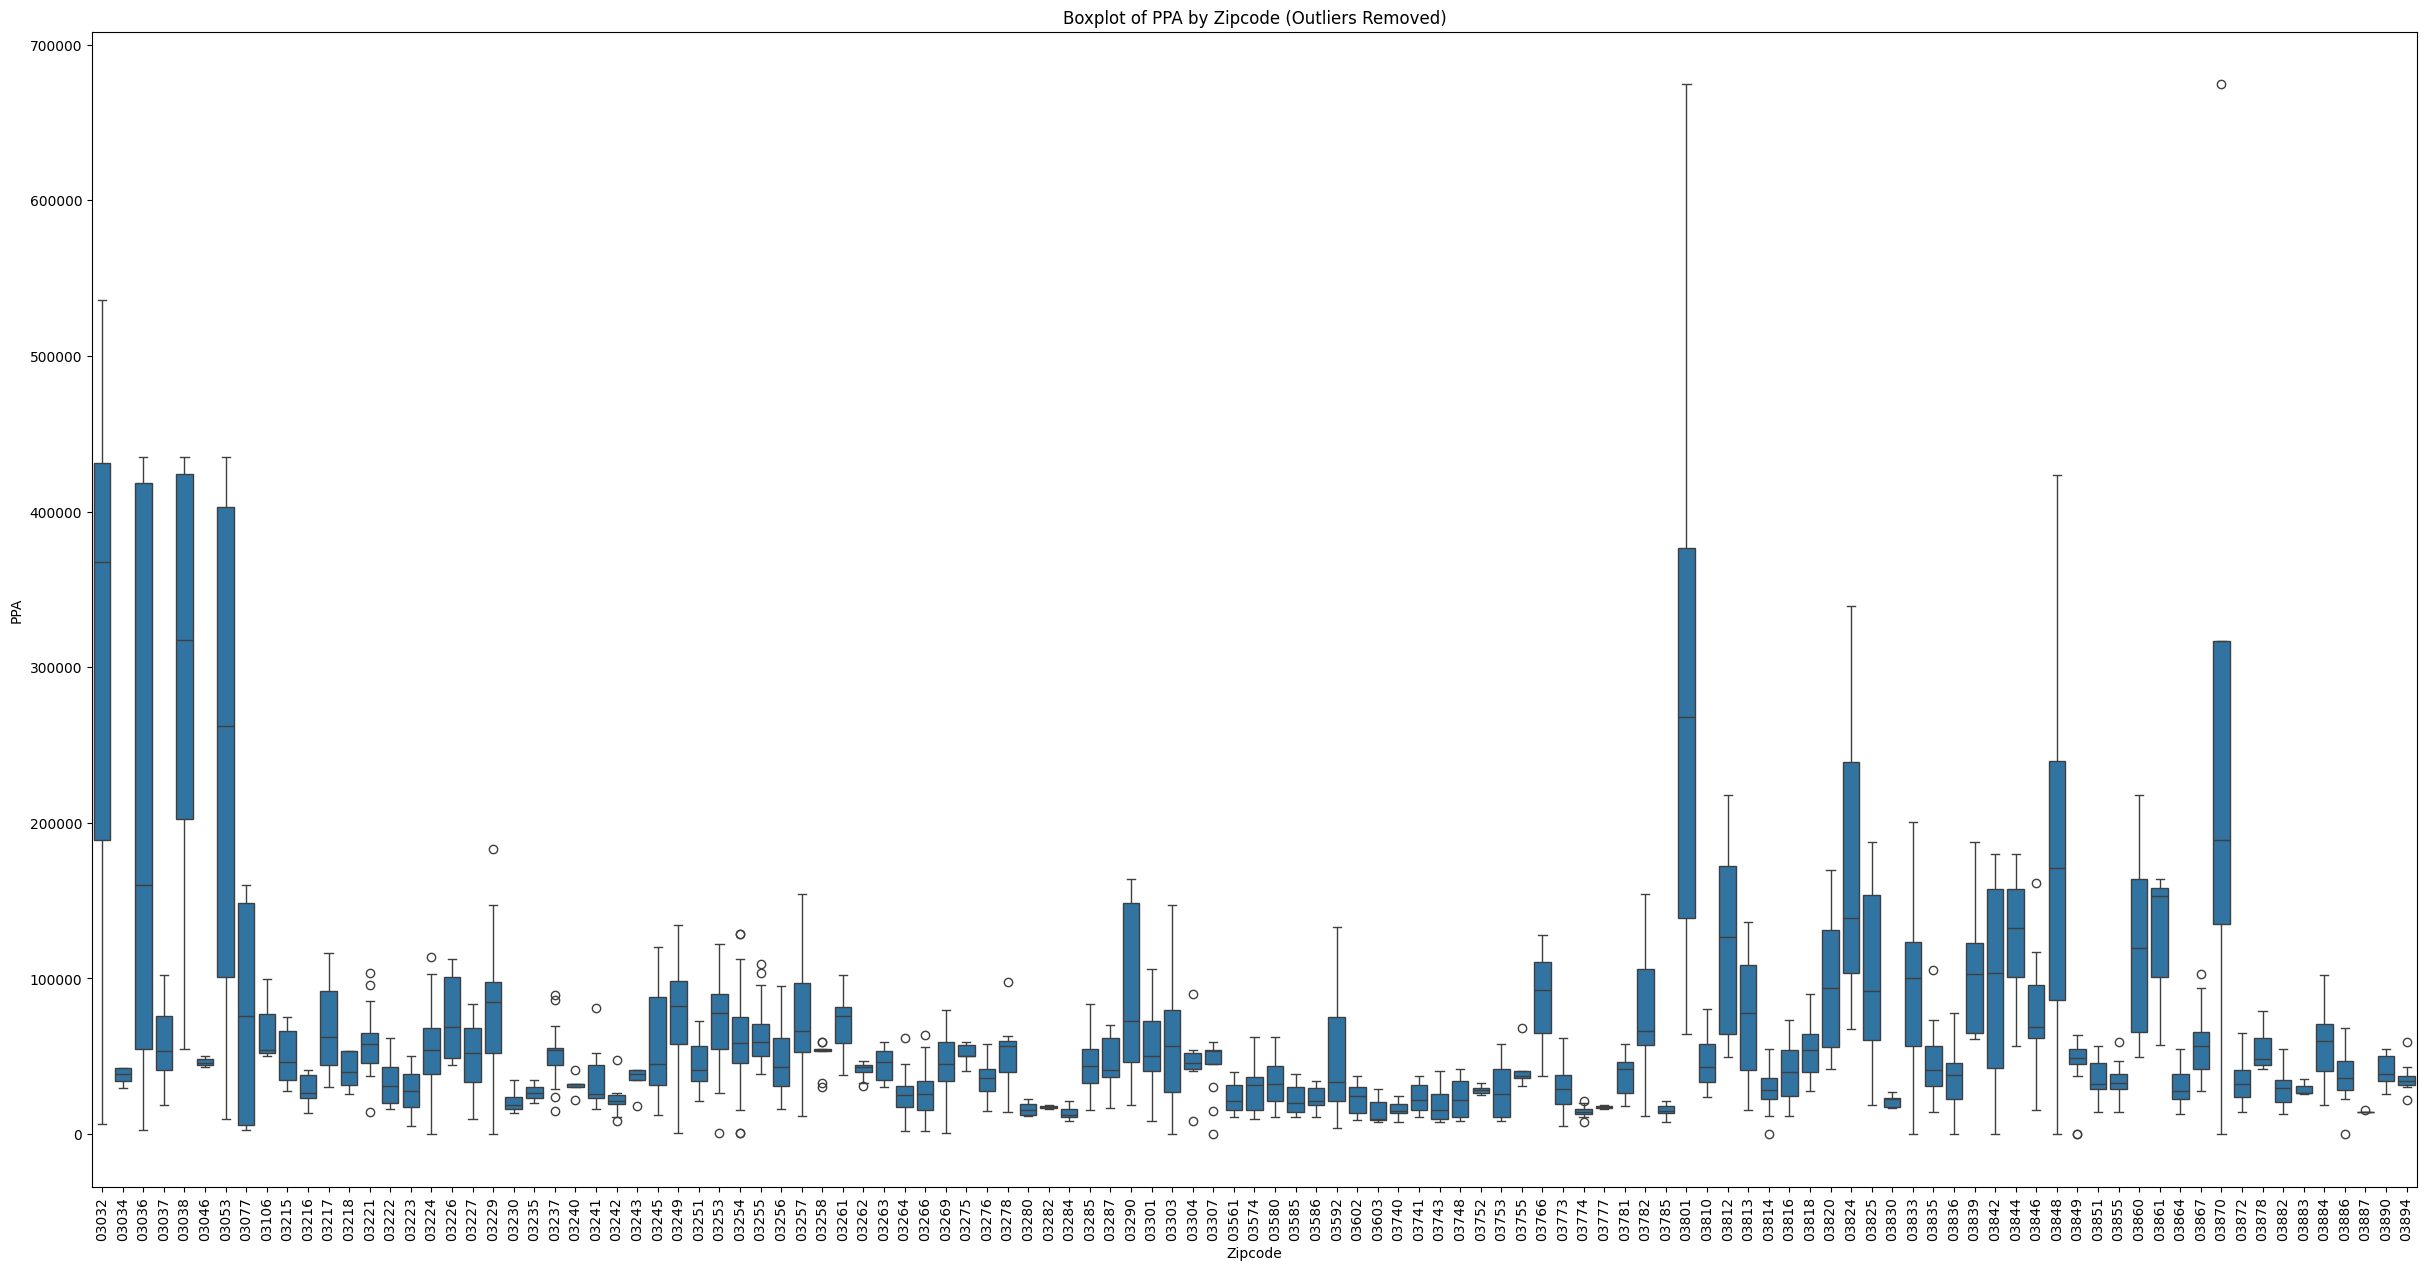

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
CSV_FILE_PATH = 'Data/Export-NH-counties (Cleaned).xlsx - Sheet1.csv'
EXCEL_FOLDER = 'Redfin'
EXCEL_FILE_PREFIX = 'Letters'
current_month = datetime.datetime.now().strftime("%B")
current_year = datetime.date.today().year


# Function to remove outliers using IQR for each group
def remove_outliers(group):
    Q1 = group['PPA'].quantile(0.05)
    Q3 = group['PPA'].quantile(0.55)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['PPA'] >= lower_bound) & (group['PPA'] <= upper_bound)]

# Load data
df = pd.read_excel(f'{EXCEL_FOLDER}/{EXCEL_FILE_PREFIX}_{current_month}_{current_year}.xlsx', dtype={'Zipcode': str})

# Calculate Price Per Acre (PPA)
df['PPA'] = round(df['Price'] / df['Size'], 2) # type: ignore
df['Offer'] = round(df['PPA'] * 0.4, 2) # type: ignore

# Remove outliers for PPA within each zipcode group
df_cleaned = df.groupby('Zipcode').apply(remove_outliers).reset_index(drop=True)

df1 = pd.read_csv(CSV_FILE_PATH, dtype={'ZIP': str})

all_zip = df['Zipcode'].unique()
zips = df1['ZIP'].dropna().unique()

needed_zips = []
for zip in zips:
    if zip not in all_zip:
        needed_zips.append(zip)
needed_zips += df_cleaned.groupby('Zipcode')['PPA'].agg('count')[df_cleaned.groupby('Zipcode')['PPA'].agg('count') < 3].sort_values(ascending=False).index.to_list()

# List of ZIP codes to drop
zipcodes_to_drop = ['03042', '03862', '03840', '03837', '03826', '03823', '03819', '03044',
                    '03858', '03779', '03869', '03745', '03605', '03873', '03874', '03268',
                    '03234', '03225', '03087', '03079', '03841', '03854', '03857', '03811',
                    '03832', '03780', '03771', '03768', '03601', '03279', '03885', '03784', 
                    '03293', '03765', '03063', '03856']

# Filter out the ZIP codes
df_cleaned = df_cleaned[~df_cleaned['Zipcode'].isin(zipcodes_to_drop)]

# Save the cleaned DataFrame to a new CSV file
round(df_cleaned.groupby('Zipcode')['PPA'].agg('median')  * 0.4, 2).to_csv('Cleaned Zipcodes.csv')

print("Unwanted ZIP codes removed and dataset saved successfully.")

# Plotting
plt.figure(figsize=(30, 15))
sns.boxplot(x='Zipcode', y='PPA', data=df_cleaned)
plt.xticks(rotation=90)
plt.title('Boxplot of PPA by Zipcode (Outliers Removed)')
plt.show()


In [ ]:
df_cleaned.groupby('Zipcode')['PPA'].agg('count').plot(kind='bar', figsize=(30 , 15));

In [3]:
df1 = pd.read_csv(CSV_FILE_PATH, dtype={'ZIP': str})

all_zip = df['Zipcode'].unique()
zips = df1['ZIP'].dropna().unique()

needed_zips = []
for zip in zips:
    if zip not in all_zip:
        needed_zips.append(zip)
needed_zips += df_cleaned.groupby('Zipcode')['PPA'].agg('count')[df_cleaned.groupby('Zipcode')['PPA'].agg('count') < 3].sort_values(ascending=False).index.to_list()
needed_zips

['03784',
 '03293',
 '03765',
 '03063',
 '03856',
 '03044',
 '03079',
 '03874',
 '03873',
 '03869',
 '03858',
 '03841',
 '03837',
 '03823',
 '03819',
 '03779',
 '03745',
 '03268',
 '03225',
 '03780',
 '03811',
 '03771',
 '03832',
 '03768',
 '03854',
 '03857',
 '03601',
 '03279',
 '03885']